# Generates a flow (demand) file
#### Either fully random or it is possible to determine some main roads and side roads and generate different demand levels on them

In [1]:
from read_roadmap import read_roadmap
from write_json import write_json_flow_file
from plot_histogram import plot_distribution

from collections import Counter
import numpy as np

In [2]:
left_right = {i: [f"road_0_{i}_0", f"road_30_{e}_0"] for (i,e) in zip(range(1, 12), [1,2,3,4,5,6,6,9,9,10,11])}
right_left = {i: [f"road_31_{i}_2", f"road_1_{i}_2"] for i in range(1, 12) if i not in {7, 8}}
down_top = {i: [f"road_{i}_0_1", f"road_{i}_11_1"] for i in range(1, 31)}
top_down = {i: [f"road_{i}_12_3", f"road_{i}_1_3"] for i in range(1, 31)}

avenue_dicts = [left_right, right_left]
street_dicts = [down_top, top_down]

def create_dic(dicts):
    created_dic = {}
    index = 0
    for d in dicts:
        for key, value in d.items():
            created_dic[index] = value
            index += 1
            
    return created_dic


avenues = create_dic(avenue_dicts)
streets = create_dic(street_dicts)

# Reorder the dictionary keys
avenues = {i: avenues[i] for i in range(len(avenues))}
streets = {i: streets[i] for i in range(len(streets))}

print(len(avenues))
len(streets)

20


60

In [3]:
def main(subdirect, random_routes, random_vehicle_parameters):
    
    Road_map_Json = f"../Simulation_Results/{subdirect}/roadnet.json"
    Dir_FlowFile_Json = f"../Simulation_Results/{subdirect}/"
    FlowFile_Json = "flow.json"
    
    # if we want inflow / outflow from specific lanes, we can just overwrite roads_IN and roads_OUT
    roads_IN, roads_OUT, road_adj_to_IN, roads_INSIDE = read_roadmap(Road_map_Json)
    
    # "Fixed" or random vehicle routes (e.g. main and side roads)
    # ratio: what percentage [0,1] of all possible inflow-outflow combinations will have vehicles
    # effective_interval: what is the effective interval between 2 vehicles on a road (even with multiple routes starting from the same road)
    if random_routes:
        # what percentage [0,1] of all possible inflow and outflow combinations will be considered
        parameters = {
            "traffic_ratio_out": 0.7,
            "traffic_ratio_in": 0.002,
            "interval": 70.0
        }
        
    else:
        # just used to determine side roads
        avenues_and_streets = set(element for sublist in list(avenues.values()) + list(streets.values()) for element in sublist)
        
        parameters = {
            # store all road names
            "avenues_dic": avenues,
            "streets_dic": streets,
            "side_roads": roads_IN.union(roads_OUT).difference(avenues_and_streets),
            
            # all demand generation parameters
            "avenues" : {"ratio": 1, "effective_interval": 45},
            "streets": {"ratio": 1, "effective_interval": 60},
            "mtm": {"ratio": 0, "effective_interval": 50},
            "mts": {"ratio": 0, "effective_interval": 45},
            "sts": {"ratio": 0, "effective_interval": 45},    # effective interval only works if start time = 0
            "stm": {"ratio": 0, "effective_interval": 40},
            "ito": {"ratio": 0, "effective_interval": 45},
            "oti": {"ratio": 0, "effective_interval": 45},
            "iti": {"ratio": 0, "effective_interval": 40},
            "horizontal": {"ratio": 0, "effective_interval": 45},
            "top": {"ratio": 0, "effective_interval": 30},
            "left": {"ratio": 0, "effective_interval": 30},
            "bottom": {"ratio": 0, "effective_interval": 30},
            "only_bottom": {"ratio": 0, "effective_interval": 5},
            "only_top": {"ratio": 0, "effective_interval": 9},
        }
        
            

    
    # Fixed or random vehicle parameters
    if random_vehicle_parameters:
        write_json_flow_file(
            vehLen =  5,
            vehWidth =  2,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            parameters = parameters,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
        
    else:
        routes_dict, num_vehicles = write_json_flow_file(
            vehLen =  5.0,
            vehWidth =  2.0,
            vehMaxPosAcc = 3.0,
            vehMaxNegAcc = 4.5,
            vehUsualPosAcc = 2.0,
            vehUsualNegAcc = 3.5,
            vehMinGap = 2.5, # 2.5
            vehMaxSpeed =  8.333, # 14 m/s ~ 50 km/h
            vehHeadwayTime = 10,
            parameters = parameters,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            roads_INSIDE = roads_INSIDE,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
    
        # Plot distribution of generated vehicles
        total_frequencies, total_bins = plot_distribution(routes_dict, num_vehicles)
        
        
        return total_frequencies, total_bins

{'avenues': '0/20', 'streets': '60/60'}
Number of routes generated (does not give all information about number of cars generated (different intervals))
avenues: 20
streets: 60
Total flows: 80
Successful created a flow file!


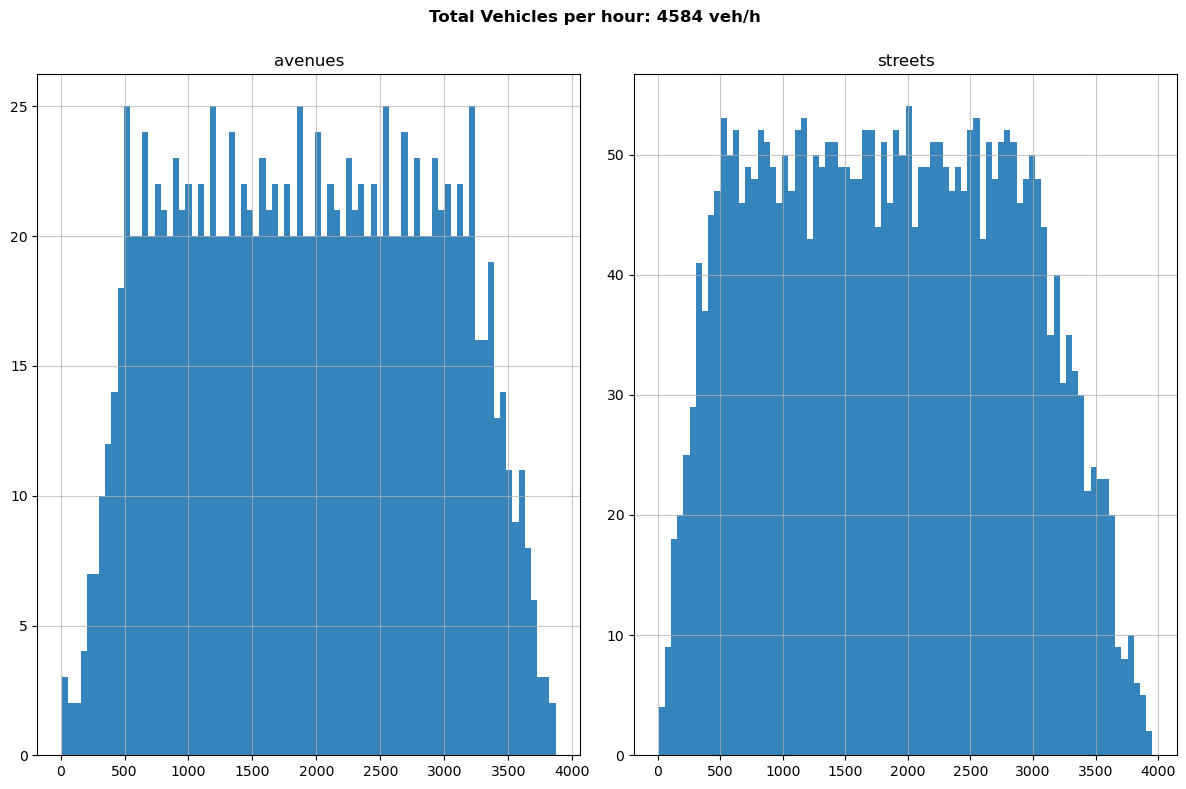

In [4]:
if __name__ == "__main__":
    
    # random vehicle routes
    random_routes = False
    
    # random vehicle parameters
    random_vehicle_parameters = False
    
    # sub directory of the roadnet file
    subdirect = "Manhattan"
    
    total_frequencies, total_bins = main(subdirect, random_routes, random_vehicle_parameters)

In [5]:
# Get the values from the dictionary
arrays = list(total_frequencies.values())

# Use zip to iterate over the corresponding elements
result = np.sum(list(zip(*arrays)), axis=1)

pair_sums = np.array([int(sum(result[i:i+2])) for i in range(0, len(result), 2)])

pair_sums

array([ 18,  44,  68, 100, 124, 148, 142, 139, 144, 139, 139, 147, 138,
       144, 142, 138, 144, 138, 139, 147, 142, 140, 143, 140, 138, 147,
       139, 143, 146, 134, 142, 121, 113, 108,  87,  74,  63,  36,  25,
        12])